# Example: Support-Vector-Machine Implementation on Dynex

Quantum computing algorithms for machine learning harness the power of quantum mechanics to enhance various aspects of machine learning tasks. Here is a summary of some prominent quantum computing algorithms for machine learning:
 
1. **Quantum Support Vector Machine (QSVM):** QSVM is a quantum-inspired algorithm that aims to classify data using a quantum kernel function. It leverages the concept of quantum superposition and quantum feature mapping to potentially provide computational advantages over classical SVM algorithms in certain scenarios.
 
 
2. **Quantum Principal Component Analysis (QPCA):** QPCA is a quantum version of the classical Principal Component Analysis (PCA) algorithm. It utilizes quantum linear algebra techniques to extract the principal components from high-dimensional data, potentially enabling more efficient dimensionality reduction in quantum machine learning.
 
 
3. **Quantum Neural Networks (QNN):** QNNs are quantum counterparts of classical neural networks. They leverage quantum principles, such as quantum superposition and entanglement, to process and manipulate data. QNNs hold the potential to learn complex patterns and perform tasks like classification and regression, benefiting from quantum parallelism.
 
 
4. **Quantum K-Means Clustering:** Quantum K-means is a quantum-inspired variant of the classical K-means clustering algorithm. It uses quantum algorithms to accelerate the clustering process by exploring multiple solutions simultaneously. Quantum K-means has the potential to speed up clustering tasks for large-scale datasets.
 
 
5. **Quantum Boltzmann Machines (QBMs):** QBMs are quantum analogues of classical Boltzmann Machines, which are generative models used for unsupervised learning. QBMs employ quantum annealing to sample from a probability distribution and learn patterns and structures in the data.
 
 
6. **Quantum Support Vector Regression (QSVR):** QSVR extends the concept of QSVM to regression tasks. It uses quantum computing techniques to perform regression analysis, potentially offering advantages in terms of efficiency and accuracy over classical regression algorithms.
 
As both, Quantum computing and Neuromorphic computing are sharing similar efficiency, all the algorithms above can be computed efficiently on the Dynex platform, but without the limitations of number of available qubits, error correction or availability.

In this example a classical classiﬁcation model, Kernel-Support Vector machine, is implemented as a Quadratic Unconstrained Binary Optimisation problem. Here, data points are classiﬁed by a separating hyperplane while maximizing the function margin. The problem is solved for a public Banknote Authentication dataset and the well-
known Iris Dataset using the **Dynex Neuromorphic Computing Platform**.

## Problem Description 

Support Vector Machines are supervised learning models that are used for classiﬁcation and regression analysis. The training set is given as {x1 ,x2 , ... xn } that are d-dimensional vectors in a some space χ ∈ Rd , where d is the dimension of each vector, i.e., the number of attributes of the training data. We are also given their labels {y1 , y2 , ..., yn }, where yi ∈ {1, −1}. SVMs use hyperplanes that separate the training data by a maximal margin. In general, SVMs allow one to project the training data in the space χ to a higher dimensional feature space F by z = Φ(x), where z ∈ F. To ﬁnd the optimal separating hyperplane having the maximum margin, the algorithm minimizes the following equation:

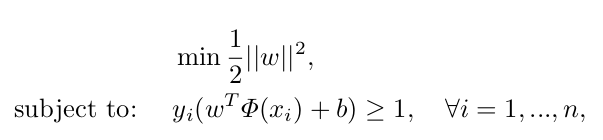

where w is the normal vector for the separating hyperplane given by the equation, w = i αi yi K(xi , x), which can be transferred into its dual form by maximising its primal Lagrangian. This is further formulated as a quadratic programming problem:

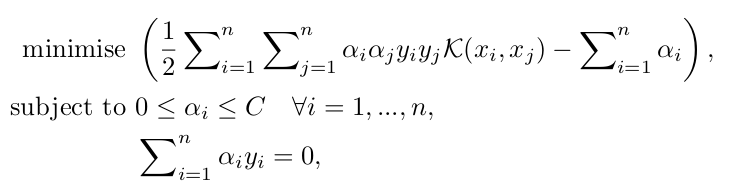

where αi is the weight assigned to the training sample xi . If αi > 0, then xi is a support vector. C is a regularisation parameter that controls the trade-oﬀ between achieving a low training error and a low testing error such that a generalization can be obtained for unseen data. The function K(xi , xj ) = Φ(xi )T Φ(xj ) is Mercer’s kernel function which allows us to calculate the dot product in high-dimensional space without explicitly knowing the non-linear Mapping. There are diﬀerent forms of kernel functions, however, the SVM with a Gaussian Kernel (or RBF-kernel) has been popular because of its ability to handle cases with non-linear relation between classes and features and doing so while having less parameters. The Gaussian Kernel is deﬁned as

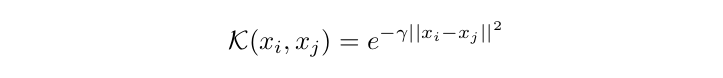

where γ > 0 is the hyperparameter. The coeﬃcients deﬁne a decision boundary that separates the vector space
in two regions, corresponding to the predicted class labels. The decision function is fully speciﬁed by the support vectors and is used to predict samples around the optimal hyperplane. It is formulated as follows:

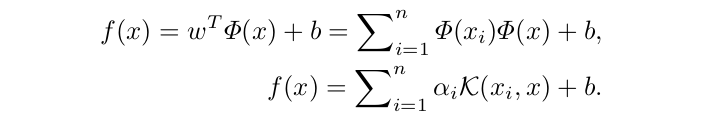

## QUBO Formulation 

To translate the quadratic programming formulation to a QUBO formulation there are two main steps. First, the input has to be translated to binary input, using the encoding:

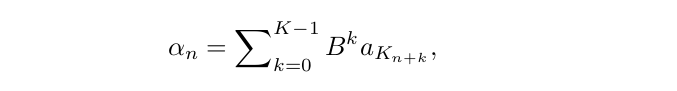

with aKn+k ∈ {0, 1} binary variables, K the number of binary variables to encode αn and B the base used for the encoding, usually B = 2. More details about the choice for K can be found in the references. The second step is to translate the constraints to the objective function, using a penalty factor ξ for a quadratic penalty. The value of ξ is determined before the training phase (if no particular value of ξ is known, a good strategy is to try exponentially growing sequences, ξ = {..., 10−4 , 10−3 , 10−2 , ...}) (We have optimized the value of ξ). 

The resulting objective function then becomes:

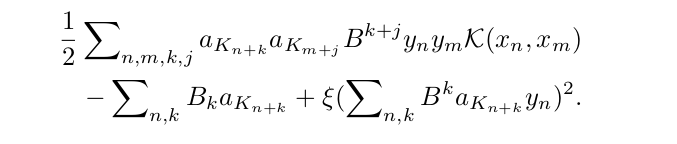

## Implementation 

First we load all the required libraries, including the Dynex SDK:

In [1]:
import dynex
import dimod

In [2]:
from itertools import product
import json
import random 
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import time 

A function to load the training data is being created. In our implementation, we will use the Standard Banknote Authenthication dataset and the well known Iris Datataset:

In [3]:
def load_data(data_file,N,validation_pts):
    training_data = np.loadtxt('./datasets/{}.txt'.format(data_file), delimiter=',')\

    for i in range(N+validation_pts):
        if(training_data[i][-1] == 0):
            training_data[i][-1] = -1

    data = training_data[:N+validation_pts, :2]
    t = training_data[:N + validation_pts, -1]

    x_min, x_max = 1000, 0
    y_min, y_max = 1000, 0
    # rescalling data
    for i in range(N+validation_pts):
        x_min = min(data[i][0], x_min)
        x_max = max(data[i][0], x_max)
        y_min = min(data[i][1], y_min)
        y_max = max(data[i][1], y_max)

    for i in range(N+validation_pts):
        data[i][0] = (data[i][0] - x_min)/(x_max - x_min)
        data[i][1] = (data[i][1] - y_min)/(y_max - y_min)

    return data,t

Next we build a Support-Vector-Machine class implementing the algorithm above. It supports five sampler types:

- **DNX** The Dynex Neuromorphic sampler
- **EXACT** A brute force exact solver which tries all combinations. Very limited problem size
- **QPU** D-Wave Quantum Processor (QPU) based D-Wave sampler
- **HQPU** D-Wave Advantage Hybrid Solver
- **SA** Simulated Annealing using the SimulatedAnnealerSampler from the D-Wave Ocean SDK

In [6]:
def delta(i, j):
    if i == j:
        return 1
    else:
        return 0

class SVM:
    def __init__(self,B,K,C,gamma,xi,N,sampler_type) -> None:
        self.gamma = gamma
        self.B = B
        self.K = K 
        self.C = C 
        self.xi = xi 
        self.N = N
        self.sampler_type = sampler_type

        if(sampler_type == 'HQPU'):
            self.sampler = LeapHybridSampler()
        if(sampler_type == 'SA'):
            self.sampler = neal.SimulatedAnnealingSampler()
        if(sampler_type == 'QPU'):
            self.sampler = EmbeddingComposite(DWaveSampler())
        if(sampler_type == 'DNX'):
            self.sampler = '';
        if(sampler_type == 'EXACT'):
            self.sampler = dimod.ExactSolver();

        pass

    def kernel(self,x, y):
        if self.gamma == -1:
            k = np.dot(x, y)
        elif self.gamma >= 0:
            k = np.exp(-self.gamma*(np.linalg.norm(x-y, ord=2)))
        
        return k

    def predict_class(self,x_test, alpha, b):
        N = len(alpha)
        f = sum([alpha[n]*self.t[n]*self.kernel(self.data[n], x_test)
                    for n in range(N)]) + b
        return f

    def train_SVM(self,data,t):
        self.data = data 
        self.t = t 
        Q_tilde = np.zeros((self.K*self.N, self.K*self.N))
        for n in range(self.N):
            for m in range(self.N):
                for k in range(self.K):
                    for j in range(self.K):
                        Q_tilde[(self.K*n+k, self.K*m+j)] = 0.5*(self.B**(k+j))*t[n]*t[m] * \
                            (self.kernel(data[n], data[m])+self.xi) - \
                            (delta(n, m)*delta(k, j)*(self.B**k))

        Q = np.zeros((self.K*self.N, self.K*self.N))
        for j in range(self.K*self.N):
            Q[(j, j)] = Q_tilde[(j, j)]
            for i in range(self.K*self.N):
                if i < j:
                    Q[(i, j)] = Q_tilde[(i, j)] + Q_tilde[(j, i)]

        size_of_q = Q.shape[0]
        qubo = {(i, j): Q[i, j]
                for i, j in product(range(size_of_q), range(size_of_q))}

        now = time.perf_counter();
        
        if(self.sampler_type == 'HQPU'):
            response = self.sampler.sample_qubo(qubo)
        if(self.sampler_type == 'SA'):
            response = self.sampler.sample_qubo(qubo, num_reads=100)
        if(self.sampler_type == 'QPU'):
            response = self.sampler.sample_qubo(qubo, num_reads=100)
        if(self.sampler_type == 'EXACT'):
            response = self.sampler.sample_qubo(qubo)
        if(self.sampler_type == 'DNX'):
            bqm = dimod.BinaryQuadraticModel.from_qubo(qubo);
            model = dynex.BQM(bqm);
            sampler = dynex.DynexSampler(model, mainnet=True, description='QSVM');
            response = sampler.sample(num_reads=100000, annealing_time = 500);
            
        #print(f'Solver Time: {time.perf_counter() - now}') 

        a = response.first.sample

        alpha = {}
        for n in range(self.N):
            alpha[n] = sum([(self.B**k)*a[self.K*n+k] for k in range(self.K)])

        b = sum([alpha[n]*(self.C-alpha[n])*(t[n]-(sum([alpha[m]*t[m]*self.kernel(data[m], data[n])
                                                    for m in range(self.N)]))) for n in range(self.N)])/sum([alpha[n]*(self.C-alpha[n]) for n in range(self.N)])

        return alpha, b

The probability or the certainty with which a class is predicted by the model, is deﬁned as the conﬁdence of the classiﬁer. The higher the absolute value of the decision function, for a given data point, the more probable
it is that the data point belongs to a particular class. We create a function to create contour plots of the decision function, with the horizontal and vertical axis representing the data points and the decision function for the corresponding points being represented by the colour gradient:

In [7]:
def  plot_figure(SVM,alpha,data,t,b,N,sampler_type):
    plt.figure()
    cm = plt.cm.RdBu

    xx, yy = np.meshgrid(np.linspace(0.0, 1.0, 80),
                            np.linspace(0.0, 1.0, 80))
    Z = []
    for row in range(len(xx)):
        Z_row = []
        for col in range(len(xx[row])):
            target = np.array([xx[row][col], yy[row][col]])
            Z_row.append(SVM.predict_class(target, alpha, b))
        Z.append(Z_row)

    cnt = plt.contourf(xx, yy, Z, levels=np.arange(-1, 1.1,
                                                    0.1), cmap=cm, alpha=0.8, extend="both")

    plt.contour(xx, yy, Z, levels=[0.0], colors=(
        "black",), linestyles=("--",), linewidths=(0.8,))
    plt.colorbar(cnt, ticks=[-1, 0, 1])

    red_sv = []
    blue_sv = []
    red_pts = []
    blue_pts = []

    for i in range(N):
        if(alpha[i]):
            if(t[i] == 1):
                blue_sv.append(data[i, :2])
            else:
                red_sv.append(data[i, :2])

        else:
            if(t[i] == 1):
                blue_pts.append(data[i, :2])
            else:
                red_pts.append(data[i, :2])

    plt.scatter([el[0] for el in blue_sv],
                [el[1] for el in blue_sv], color='b', marker='^', edgecolors='k', label="Type 1 SV")

    plt.scatter([el[0] for el in red_sv],
                [el[1] for el in red_sv], color='r', marker='^', edgecolors='k', label="Type -1 SV")

    plt.scatter([el[0] for el in blue_pts],
                [el[1] for el in blue_pts], color='b', marker='o', edgecolors='k', label="Type 1 Train")

    plt.scatter([el[0] for el in red_pts],
                [el[1] for el in red_pts], color='r', marker='o', edgecolors='k', label="Type -1 Train")

    
    plt.legend(loc='lower right', fontsize='x-small')
    plt.savefig(f'{sampler_type}.jpg')

def compute_metrics(SVM,alpha,data,t,b,N,validation_pts):
    tp, fp, tn, fn = 0, 0, 0, 0
    for i in range(N, N+validation_pts):
        predicted_cls = SVM.predict_class(data[i], alpha, b)
        y_i = t[i]
        if(y_i == 1):
            if(predicted_cls > 0):
                tp += 1
            else:
                fp += 1
        else:
            if(predicted_cls < 0):
                tn += 1
            else:
                fn += 1

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_score = tp/(tp + 1/2*(fp+fn))
    accuracy = (tp + tn)/(tp+tn+fp+fn)

    return precision,recall,f_score,accuracy



## Computation (Main-Net)

The simulations were run using the following parameter values: K = 2, B = 2, C = 3, ξ = 0.001, γ = 16. We do not intend to optimize C, γ as our aim is to study the behaviour for same hyper parameters. However ξ has been optimized by the authors in the references:

In [17]:
B = 2;
K = 2;
C = 3;
gamma = 16;
xi = 0.001;
dataPoints = 150; # size of data points
spl = "DNX";     # sampler
trainingPoints = int(dataPoints * 0.80)
validationPoints = dataPoints - trainingPoints; 
print('Training set:', trainingPoints,'validation set:',validationPoints, 'total:',dataPoints)

Training set: 120 validation set: 30 total: 150


First we load the dataset:

In [18]:
data,t = load_data('banknote_1',trainingPoints,validationPoints)

We create the Support-Vector-Machine class given the data:

In [19]:
_SVM = SVM(B,K,C,gamma,xi,trainingPoints,spl)

And finally train the SVM:

In [20]:
alpha, b = _SVM.train_SVM(data, t)

╭────────────┬───────────┬───────────┬─────────┬────────┬─────────┬───────┬──────┬──────────┬────────────╮
│   DYNEXJOB │   ELAPSED │   WORKERS │   CHIPS │      ✔ │   STEPS │   LOC │    ✔ │   ENERGY │          ✔ │
├────────────┼───────────┼───────────┼─────────┼────────┼─────────┼───────┼──────┼──────────┼────────────┤
│       5029 │      0.35 │         4 │ 1554222 │ 114176 │     500 │  4621 │ 4621 │  7272542 │ 7276642.00 │
╰────────────┴───────────┴───────────┴─────────┴────────┴─────────┴───────┴──────┴──────────┴────────────╯
╭───────────┬───────────────┬─────────┬───────┬────────────┬────────────┬───────────────┬──────────╮
│    WORKER │       VERSION │   CHIPS │   LOC │     ENERGY │    RUNTIME │   LAST UPDATE │   STATUS │
├───────────┼───────────────┼─────────┼───────┼────────────┼────────────┼───────────────┼──────────┤
│ 133963327 │ 2.3.0.SRB.234 │  100000 │ 14294 │ 7272542.00 │   0.75 min │     1.00s ago │  STOPPED │
├───────────┼───────────────┼─────────┼───────┼────────────┼─

Using the functions for plotting the graphs and printing metrics, we analyse the result:

In [ ]:
plot_figure(_SVM,alpha,data,t,b,trainingPoints,spl)

In [21]:
precision,recall,f_score,accuracy = compute_metrics(_SVM,alpha,data,t,b,trainingPoints,validationPoints)
print(f'{precision=} {recall=} {f_score=} {accuracy=}')

precision=1.0 recall=0.8823529411764706 f_score=0.9375 accuracy=0.9333333333333333


The following chart shows the results of the experiments conducted on the D-Wave system using the various samplers as described above. Note that the authors observed that the QPU is not able to ﬁnd embeddings for instances larger that 90:

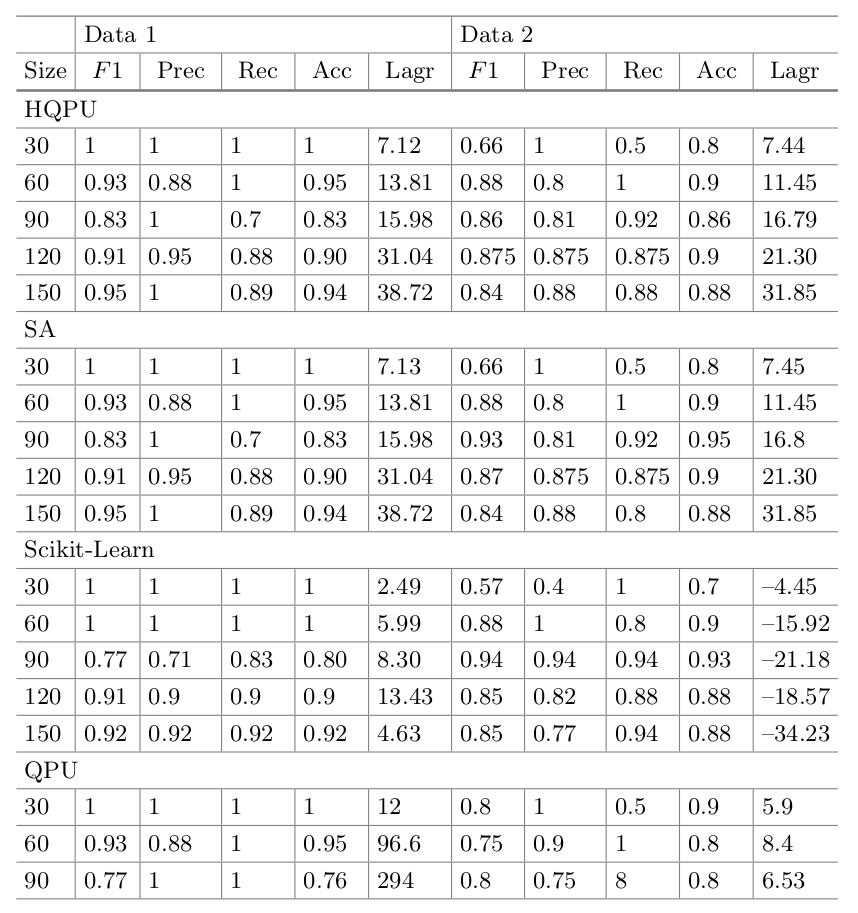

## References 

[1] Harshil Singh Bhatia and Frank Phillipson: Performance Analysis of Support Vector Machine Implementations on the D-Wave Quantum Annealer, International Conference on Computational Science, p.84-97, 2021, Springer

[2] Booth, M., Reinhardt, S.P., Roy, A.: Partitioning Optimization Problems for Hybrid Classical/Quantum Execution. Technical report, D-Wave Systems (2017)

[3] Chang, C.C., Lin, C.J.: LIBSVM: a library for support vector machines. ACM Trans. Intell. Syst. Technol. 2, 27:1–27:27.

[4] Chatterjee, R., Yu, T.: Generalized coherent states, reproducing kernels, and quantum support vector machines. Quantum Inf. Comput. 17(15–16), 1292–1306 (2017)

[5] Choi, V.: Minor-embedding in adiabatic quantum computation: I. the parameter setting problem. Quantum Inf. Process. 7(5), 193–209 (2008)

[6] Coﬀrin, C.J.: Challenges with chains: testing the limits of a d-wave quantum annealer for discrete optimization. Technical report, Los Alamos National Lab. (LANL), Los Alamos, NM (United States) (2019)

[7] Willsch, D., Willsch, M., De Raedt, H., Michielsen, K.: Support vector machines on the d-wave quantum annealer. Comput. Phys. Commun. 248, 107006 (2020)